# **DERIVING SPATIAL MAPS WITH PYFLWDIR**

# DATA


In [56]:
import os

Crs = "EPSG:29902"  # This is the default projection NZGD2000 / New Zealand Transverse Mercator 2000

# ======= PATHS =======
Input_Root = "E:\JOE3\MAIN\MODELS\WFLOW\DATA\Timoleague\Input"
Output_Root = "E:\JOE3\MAIN\MODELS\WFLOW\DATA\Timoleague\OutputPython"

# ====== FILES NAME =======
DemCorrected_Output = "Timoleague_DTM_1m.tif"
Dem_Input           = "Timoleague_DTM_1m.tif"
Ldd_Output          = "Ldd_Pyflwdir.tiff"
River_Input         = "Timoleague_River.geojson"
Slope_Output        = "Slope.tiff"
StreamOrder_Output  = "StreamOrder.tiff"
StreamSlope_Output  = "StreamSlope.tiff"
StreamTrue_Output   = "StreamTrue.tiff"
StreamWidth_Output  = "StreamWidth.tiff"

# ======= PARAMETERS =======

# == Ldd inputs ==
Ldd_MaxDepth   = -1.0 #  (float, optional) – Maximum pour point depth. Depressions with a larger pour point depth are set as pit. A negative value (default) equals an infinitely large pour point depth causing all depressions to be filled.
Ldd_RiverDepth = 2.0  # (float) – fixed depth value used to burn in the dem
StreamOrder    = 4
StreamOrderMin = 1
StreamWidth    = 2.0
StreamOrder_Type = "strahler" # <"strahler"> or <"classic">  stream order map. In the classic “bottum up” stream order map, the main river stem has order 1. Each tributary is given a number one greater than that of the river or stream into which they discharge. In the strahler “top down” stream order map, rivers of the first order are the most upstream tributaries or head water cells. If two streams of the same order merge, the resulting stream has an order of one higher. If two rivers with different stream orders merge, the resulting stream is given the maximum of the two order.

# == Other ==
NoData = 255



# Output_Root_Csv      = "D:\MAIN\MODELS\WFLOW\DATA\SouthLand\OutputCsv"

# Path_Input_Dem = os.path.join(Input_Root, Dem_Input)

# Option_Subcatchement_OR_Catchement = "Subcatchement"  # 'Subcatchement' 'Catchement'


# **PLOTS**

In [57]:
from matplotlib import pyplot
import matplotlib.cm as cm
from rasterio.plot import show


def PLOT_MAPS(Data, Label, Min, Max, Cmap="viridis"):
   pyplot.imshow(Data, cmap=Cmap, vmin=Min, vmax=Max)
   pyplot.title(Label)
   pyplot.colorbar(label=Label)
   pyplot.show()


## **TOOLS:**: *Reading Rivers network in geopandas*

In [ ]:
import geopandas
import os as os

Path_Input_River_Geojson = os.path.join(Input_Root, River_Input)

River_Geopandas = geopandas.read_file(Path_Input_River_Geojson)
# River_GeoDataFrame = geopandas.GeoDataFrame(River_Geopandas)

River_GeoDataFrame = geopandas.GeoDataFrame.from_features(River_Geopandas)


## **TOOLS:** *DEM -> FlowDirection (LDD)*

In [59]:
"""Note: This quick solution does require loading the entire flow direction map into memory (Flwdir_D8.load()) which can be a problem for large maps. The implementation inside hydromt_wflow works differently and makes use of options in xarray to perform computations in a chucked way (so loading only chuncks of the maps into memory to perform calculations instead of the whole map)

xarray.apply_ufunc
https://docs.xarray.dev/en/latest/generated/xarray.apply_ufunc.html

Parameters
:
                        da_elv (2D xarray.DataArray) – elevation raster

                        max_depth (float, optional) – Maximum pour point depth. Depressions with a larger pour point depth are set as pit. A negative value (default) equals an infinitely large pour point depth causing all depressions to be filled.

                        outlets ({'edge', 'min', 'idxs_pit'}) – Position of basin outlet(s) If ‘edge’ (default) all valid elevation edge cell are considered. If ‘min’ only the global minimum elevation edge cell is considered and all flow is directed to this cell. If ‘idxs_pit’ the linear indices of the outlet cells are provided in idxs_pit.

                        idxs_pit (1D array of int) – Linear indices of outlet cells.

                        gdf_riv (geopandas.GeoDataArray, optional) – River vector data. If provided, the river cells are burned into the dem. Different methods can be used to burn in the river cells, see riv_burn_method.

                        riv_burn_method ({'uparea', 'rivdph', 'fixed'}, optional) – Method to burn in river vector to aid the flow direction derivation, requires gdf_riv. If ‘fixed’ (default) a fixed river depth rivdph value is used to burn in the river cells. If ‘rivdph’ the rivdph column is used to burn in the river cells directly. If ‘uparea’ the uparea column is used to create a synthetic river depth based on max(1, log10(uparea[m2])).

                        riv_depth (float) – fixed depth value used to burn in the dem

                        **kwargs – Additional keyword arguments that are passed to the pyflwdir.dem.fill_depressions() function.

"""

import hydromt
from pyflwdir.core_conversion import d8_to_ldd
import xarray
import numpy as np


def DEM_2_LDD_HYDROMT(
   Path_Input,
   Path_Output,
   Ldd_MaxDepth=Ldd_MaxDepth,
   Ldd_RiverDepth=Ldd_RiverDepth,
   NoData=NoData,
   Outlets="edge",
   River=[],
):
   # Read elevation data using hydromt which will transform the data into xarray
   Dem = hydromt.io.open_raster(Path_Input)

   # Deriving the D8 from DEM
   Flwdir_D8 = hydromt.flw.d8_from_dem(
      da_elv=Dem,
      max_depth=Ldd_MaxDepth,
      gdf_riv=River,
      outlets=Outlets,
      idxs_pit=None,
      riv_burn_method="fixed",
      riv_depth=Ldd_RiverDepth,
   )

   # Converting D8-> Ldd as required by WFLOW model
   Flwdir_Ldd_Pyflwdir = xarray.apply_ufunc(d8_to_ldd, Flwdir_D8.load())

   # Save output
   Flwdir_Ldd_Pyflwdir.raster.to_raster(Path_Output, nodata=NoData)

   return Flwdir_Ldd_Pyflwdir


### ***Computting ldd***

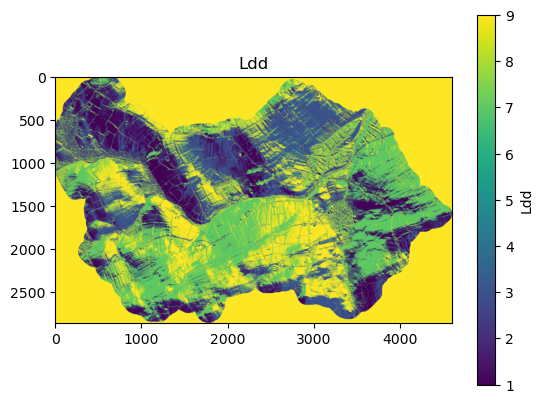

In [60]:
import os as os

Path_Input_Dem = os.path.join(Input_Root, Dem_Input)
Path_Output_Ldd = os.path.join(Output_Root, Ldd_Output)

Ldd_Pyflwdir = DEM_2_LDD_HYDROMT(
   Path_Input_Dem,
   Path_Output_Ldd,
   Ldd_MaxDepth=Ldd_MaxDepth,
   Ldd_RiverDepth=Ldd_RiverDepth,
   NoData=NoData,
   Outlets="edge",
   River=River_Geopandas,
)

PLOT_MAPS(Ldd_Pyflwdir, "Ldd", 1, 9)


## Correcting for DEM

## **TOOLS:** *DEM -> SLOPE*

In [61]:
import rasterio
import pyflwdir

def DEM_2_SLOPE(Path_Input_Dem, Path_Output_Slope):
   # Read elevation data using rasterio
   with rasterio.open(Path_Input_Dem, "r") as src:
      elevtn = src.read(1)
      nodata = src.nodata
      transform = src.transform
      crs = src.crs
      #  extent = np.array(src.bounds)[[0, 2, 1, 3]]
      latlon = src.crs.is_geographic
      prof = src.profile

   Slope_Pyflwdir = pyflwdir.dem.slope(
      elevtn, nodata=src.nodata, latlon=latlon, transform=transform
   )

   # Write to tiff file
   prof.update(dtype=Slope_Pyflwdir.dtype, nodata=False)
   with rasterio.open(Path_Output_Slope, "w", **prof) as src:
      src.write(Slope_Pyflwdir, 1)

   return Slope_Pyflwdir


### ***Computting Slope***

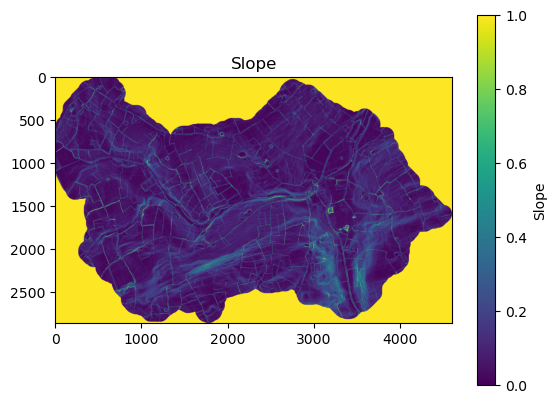

In [62]:
import os as os

Path_Input_Dem = os.path.join(Input_Root, DemCorrected_Output)
Path_Output_Slope = os.path.join(Output_Root, Slope_Output)

Slope_Pyflwdir = DEM_2_SLOPE(Path_Input_Dem, Path_Output_Slope)

PLOT_MAPS(Slope_Pyflwdir, "Slope", 0, 1)


## **TOOLS:** *FlowDirection -> Streams*


In [72]:
import rasterio
import pyflwdir
import numpy as np

def FLOWDIRECTION_2_STREAMS(
   FlowDirection_Pyflwdir,
   Path_Input_Dem,
   Path_Input_Ldd,
   Path_Output_StreamOrder,
   Path_Output_StreamSlope,
   Path_Output_StreamWidth,
   Path_Output_StreamTrue,
   Slope_Pyflwdir,
   StreamOrderMin=0,
   StreamWidth=3.0,
   Type="strahler",
):
    #  Type= "strahler" or "classic"

    # Read elevation data using rasterio just for initialisation
   with rasterio.open(Path_Input_Dem, "r") as src:
      elevtn = src.read(1)
      nodata = src.nodata
      transform = src.transform
      crs = src.crs
      latlon = src.crs.is_geographic
      prof = src.profile


    # === STREAM ORDERS ===================================

    # Read D8 data using rasterio
   with rasterio.open(Path_Input_Ldd, "r") as src:
      FlowDirection_Rasterio = src.read(1)
      nodata = src.nodata
      transform = src.transform
      crs = src.crs
      latlon = src.crs.is_geographic
      prof = src.profile

   FlowDirection_Pyflwdir = pyflwdir.from_array( FlowDirection_Rasterio, ftype="ldd", transform=transform, latlon=latlon, cache=True)

   # Stream order
   Streams_StreamOrder0 = FlowDirection_Pyflwdir.stream_order(type=Type)

   # Masking data were Stream order > 1
   Nx, Ny = np.shape(Streams_StreamOrder0)
   Streams_StreamOrder = np.ma.empty(shape=(Nx, Ny))
   for iX in range(Nx):
      for iY in range(Ny):
         if Streams_StreamOrder0[iX, iY] >= StreamOrderMin:
            Streams_StreamOrder[iX, iY] = Streams_StreamOrder0[iX, iY]

   prof.update(dtype=Streams_StreamOrder.dtype, nodata=False)
   with rasterio.open(Path_Output_StreamOrder, "w", **prof) as src:
      src.write(Streams_StreamOrder, 1)


    # === STREAMS TRUE ==================================
   StreamsTrue = np.greater(Streams_StreamOrder, StreamOrderMin)

   prof.update(dtype=Streams_StreamOrder.dtype, nodata=False)
   with rasterio.open(Path_Output_StreamTrue, "w", **prof) as src:
        src.write(StreamsTrue, True)

    # === STREAMS WIDTH ===
   Streams_Width = StreamsTrue * StreamWidth
   prof.update(dtype=Streams_StreamOrder.dtype, nodata=False)
   with rasterio.open(Path_Output_StreamWidth, "w", **prof) as src:
        src.write(Streams_Width, 1)

    # === STREAM SLOPE ====
   Nx, Ny = np.shape(StreamsTrue)
   Streams_Slope = np.ma.empty(shape=(Nx, Ny))

    # Masking only data were we have slope
   for iX in range(Nx):
      for iY in range(Ny):
         if StreamsTrue[iX, iY] == True:
            Streams_Slope[iX, iY] = Slope_Pyflwdir[iX, iY]

   prof.update(dtype=Slope_Pyflwdir.dtype, nodata=False)
   with rasterio.open(Path_Output_StreamSlope, "w", **prof) as src:
      src.write(Streams_Slope, 1)

   return StreamsTrue, Streams_Slope, Streams_StreamOrder, Streams_Width


### ***Computting Streams***

In [74]:
Path_Input_Ldd = os.path.join(Output_Root, Ldd_Output)
Path_Output_StreamOrder = os.path.join(Output_Root, StreamOrder_Output)
Path_Output_StreamSlope = os.path.join(Output_Root, StreamSlope_Output)
Path_Output_StreamWidth = os.path.join(Output_Root, StreamWidth_Output)
Path_Output_StreamTrue = os.path.join(Output_Root, StreamTrue_Output)

StreamsTrue, Streams_Slope, Streams_StreamOrder, Streams_Width = FLOWDIRECTION_2_STREAMS(
   Ldd_Pyflwdir,
   Path_Input_Dem,
   Path_Input_Ldd,
   Path_Output_StreamOrder,
   Path_Output_StreamSlope,
   Path_Output_StreamWidth,
   Path_Output_StreamTrue,
   Slope_Pyflwdir,
   StreamOrderMin=StreamOrderMin,
   StreamWidth=StreamWidth,
   Type=StreamOrder_Type,
)


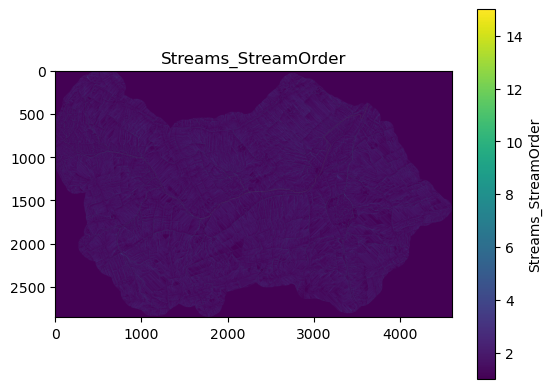

In [65]:
PLOT_MAPS(Streams_StreamOrder, "Streams_StreamOrder", 1, 15)


## **TOOLS**: *Gauging station*

In [ ]:
fn_station = "test_stations.csv"
with open(fn_station, "r", encoding="utf8") as f:
    txt = f.read()
print(txt)


## **TOOLS:** *FlowDirections -> Catchements*

In [66]:
# import geopandas as gpd
import numpy as np
import geopandas as gpd
import rasterio
import pyflwdir

# import python_utils
import os as os


def FLOWDIRECTION_2_CATCHEMENT(
    FlowDirection_Pyflwdir,
    Path_Input_Dem,
    Path_Output_Catchment,
    Xcoord=147704.593,
    Ycoord=41038.670,
    Option_Catchement="Subbasins",
    Crs=29902,
):
    # Read elevation data using rasterio
    with rasterio.open(Path_Input_Dem, "r") as src:
        elevtn = src.read(1)
        nodata = src.nodata
        transform = src.transform
        crs = src.crs
        latlon = src.crs.is_geographic
        prof = src.profile


# # Define output location
# # x,y = np.array([Xcoord, Ycoord])

# gdf_out = gpd.GeoSeries(gpd.points_from_xy(x, y, crs=Crs))

# # delineate subbasins
# subbasins = FlowDirection_Pyflwdir.basins(xy=(x, y), streams=FlowDirection_Pyflwdir.stream_order() >= 4)
# # vectorize subbasins using the vectorize convenience method from utils.py
# gdf_bas = vectorize(subbasins.astype(np.int32), 0, FlowDirection_Pyflwdir.transform, name="basin")
# gdf_bas.head()

# # # Delinating catchements
# # if  Option_Catchement == "Subbasins":
# #    Subbassins, Idxs_out = FlowDirection_Pyflwdir.subbasins_streamorder(min_sto=7, mask=None)

# # prof.update(dtype=Subbassins.dtype, nodata=False)
# # with rasterio.open(Path_Output_Catchment, "w", **prof) as src:
# #    src.write(Subbassins, 1)

# # return Subbassins, Idxs_out
# return gdf_bas


# =========================================================================================================

## DEM TASKS

In [67]:
from matplotlib import pyplot
import matplotlib.cm as cm
from rasterio.plot import show

pyplot.imshow(Ldd_Array, cmap="viridis", vmin=1, vmax=9)
pyplot.title("Ldd")
pyplot.colorbar(label="Ldd")
pyplot.show()


NameError: name 'Ldd_Array' is not defined

### Streams

In [ ]:
pyplot.imshow(Streams_StreamOrder, cmap="viridis", vmin=1, vmax=10)
pyplot.title("StreamOrder")
pyplot.colorbar(label="StreamOrder")


In [ ]:
pyplot.imshow(Streams_StreamOrder, cmap="viridis", vmin=1, vmax=10)
pyplot.title("StreamOrder")
pyplot.colorbar(label="StreamOrder")


### Catchement boundary

In [ ]:
Path_Output_Catchment = os.path.join(Output_Root, "Catchment.tiff")
Subbassins, Idxs_out = FLOWDIRECTION_2_CATCHEMENT(
   FlowDirection_Pyflwdir,
   Path_Input_Dem,
   Path_Output_Catchment,
   Option_Catchement="Subbasins",
)


#### DEM data: *wflow_dem*


### River network

#### Gauges stations: *wflow_gauges_grdc*

#### ldd maps: *wflow_ldd*

### Looking for pits

#### Subcatchement: *wflow_subcatch*

### Reduce extend based on catchment


### River network

##### Slope: *Slope*

### MAPS derived from rivers

#### River location: *wflow_river*

#### River length: *wflow_riverlength*

#### River width: *wflow_riverwidth*


#### River slope: *RiverSlope*

## OUTPUT CSV

## NetCDF Static data

## FORCING DATA

### Precipitation


#### Potential evapotranspiration

# OLD CODE

In [ ]:
import hydromt
import pyflwdir
import rasterio


def DEM_2_LDD_HYDROMT0(Path_Input, Path_Output, Ldd_MaxDepth=-1.0, Outlets="edge"):
   # Read elevation data using hydromt which will transform the data into xarray
   Dem = hydromt.io.open_raster(Path_Input)

   Flwdir_D8 = hydromt.flw.d8_from_dem(
      Dem, max_depth=Ldd_MaxDepth, outlets=Outlets, idxs_pit=None
   )

   Flwdir_D8.raster.to_raster(Path_Output)

   # Read D8 data using rasterio
   with rasterio.open(Path_Output, "r") as src:
      D8 = src.read(1)
      nodata = src.nodata
      transform = src.transform
      crs = src.crs
      latlon = src.crs.is_geographic
      prof = src.profile

   # Converting D8 -> ldd
   Flwdir_Ldd_Pyflwdir = pyflwdir.core_conversion.d8_to_ldd(D8)

   # Write to tiff file
   prof.update(dtype=Flwdir_Ldd_Pyflwdir.dtype, nodata=False)
   with rasterio.open(Path_Output, "w", **prof) as src:
      src.write(Flwdir_Ldd_Pyflwdir, 1)

   return Flwdir_Ldd_Pyflwdir


In [ ]:
import rasterio
import numpy as np
import pyflwdir


def DEM_2_LDD_PYFLWDIR(
   Path_Input_Dem, Path_Output_FlowDirection, Ldd_MaxDepth=-1.0, Outlets="edge"
):
   # Read elevation data using rasterio
   with rasterio.open(Path_Input_Dem, "r") as src:
      elevtn = src.read(1)
      nodata = src.nodata
      transform = src.transform
      crs = src.crs
      latlon = src.crs.is_geographic
      prof = src.profile

   # returns FlwDirRaster object
   Ldd_Pyflwdir = pyflwdir.from_dem(
      data=elevtn,
      nodata=src.nodata,
      max_depth=Ldd_MaxDepth,
      outlets=Outlets,
      transform=transform,
      latlon=latlon,
   )

   Ldd_Array = Ldd_Pyflwdir.to_array(ftype="ldd")

   # Write to tiff file
   prof.update(dtype=Ldd_Array.dtype, nodata=False)
   with rasterio.open(Path_Output_FlowDirection, "w", **prof) as src:
      src.write(Ldd_Array, 1)

   return Ldd_Pyflwdir, Ldd_Array
